# Transfer Learning

Transfer learning is one of the most up and rising areas in Deep Learning. It is based on the principle "_surely someone has spent the time crafting the right model for the job_". In other words, we can leverage an existing neural network architecture proven to work on problems similar to the one at hand, using the already learned patterns on the original data to apply to a more specific case use.

This process often leads to good results with less resources, both in data and in time spent training.


## Setup


### Importing packages


In [1]:
import random
import matplotlib.pyplot as plt

from pathlib import Path
from timeit import default_timer as timer

import torch
import torchinfo
import torchvision

import torch.nn as nn
from torchvision import transforms

from modules import data_setup, engine
from helper_functions.helper_functions import plot_loss_curves, pred_and_plot_image

### Setting device


In [2]:
# Setting mps/cuda as device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "mps" if torch.mps.is_available() else "cpu"

## Importing and processing data


In [3]:
# Setting up paths
data_path = Path("../data/")
image_path = data_path / "pizza_steak_sushi"

# Setting up dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

### Creating manual DataLoaders

Now that we got some data, we want to turn it into PyTorch DataLoaders. To do this, we can use the `create_dataloaders` function in the `modules/data_setup.py` file. But since we're using a pre-trained model, we need to preprocess our data in the same way the original data was processed.

The line:

```python
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
```

Is required for used for all pre-trained models (at least those available at PyTorch), "_All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W) where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean=[0.485, 0.456, 0.406]`, and `std=[0.229, 0.224, 0.225]`_".

When we normalize our data with these values, it ensures the image's values are distributed in the same way as the original data.


In [4]:
# Creating transforms pipeline
manual_transforms = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [5]:
# Creating Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms,
    test_transform=manual_transforms,
    batch_size=32,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x14dae1650>,
 ['pizza', 'steak', 'sushi'])

### Creating automatic dataloaders


In [6]:
# Getting pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
# Get transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [8]:
# Creating Dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=auto_transforms,
    test_transform=auto_transforms,
    batch_size=32,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x14daf7f10>,
 ['pizza', 'steak', 'sushi'])

## Setting up a pre-trained model

There are plenty of places where you can find pre-trained models, such as [PyTorch Domains Libraries](https://pytorch.org/domains/), [Torch Image Models (timm library)](https://timm.fast.ai), [HuggingFaceHub](https://huggingface.co/docs/hub/en/models-the-hub), [Papers with code SOTA](https://github.com/paperswithcode).

The model best fit for _your_ problem isn't preset, you should always experiment with models that in some way shape or form, resembles your data, or objective. Besides this, there are other factors that should be considered:

1. Speed
2. Size
3. Performance

These factors are usually interconnected, with it being a "_short-blanket_", where in order to find the model that is best at one of these factors, you would sacrifice quality in one of them (especially in the case of performance/speed). At this point you've gained enough experience in order for this to be second nature, but still important to note.

All that considered, the model we'll use is the `EfficientNet-B0`.


In [9]:
# Creating an instance of EfficientNet-B0
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [10]:
# Getting info on the model
torchinfo.summary(
    model=model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### Freezing base layers and Setting up model's "head"

A model's _head_ refers to the classifier at the end of a specific model. When importing a pre-trained model, it has its own classifier, that was used to train that model to its original data.

Therefore, in order to use the newly imported model in our own data, we need to change the classifier so that the model's _body_ (the rest of the architecture) works for our data.

There are plenty of types of Transfer Learning, but our case will use _"Feature Extraction"_, where the weights of the original model's body will be frozen (not trained), and the only part of the model that will train is the head (classifier.)


In [11]:
# Freezing base layers
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
# Creating new head
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True),
).to(device)

In [13]:
# Reanalysing model summary
torchinfo.summary(
    model=model,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Training and evaluating model


In [14]:
# Setting optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Setting up loss
loss_fn = nn.CrossEntropyLoss()

In [15]:
# Ensuring model is in device
model = model.to(device)

# Starting timer
start_time = timer()

# Setting up training and saving results
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=70,
    device=device,
)

# Ending timer
end_time = timer()

print(
    f"""
======================================
Total training time: {end_time - start_time:.3f} seconds |
======================================
    """
)

  0%|          | 0/70 [00:00<?, ?it/s]


Epoch:                       |   1   |  
Train Loss:                  | 1.037 |

Train Accuracy:              | 0.406 |            
--------------------------------------
Test Loss:                   | 0.864 |

Test Accuracy:               | 0.703 |
              

Epoch:                       |   2   |  
Train Loss:                  | 0.900 |

Train Accuracy:              | 0.605 |            
--------------------------------------
Test Loss:                   | 0.808 |

Test Accuracy:               | 0.621 |
              

Epoch:                       |   3   |  
Train Loss:                  | 0.773 |

Train Accuracy:              | 0.734 |            
--------------------------------------
Test Loss:                   | 0.670 |

Test Accuracy:               | 0.855 |
              

Epoch:                       |   4   |  
Train Loss:                  | 0.645 |

Train Accuracy:              | 0.887 |            
--------------------------------------
Test Loss:                   |

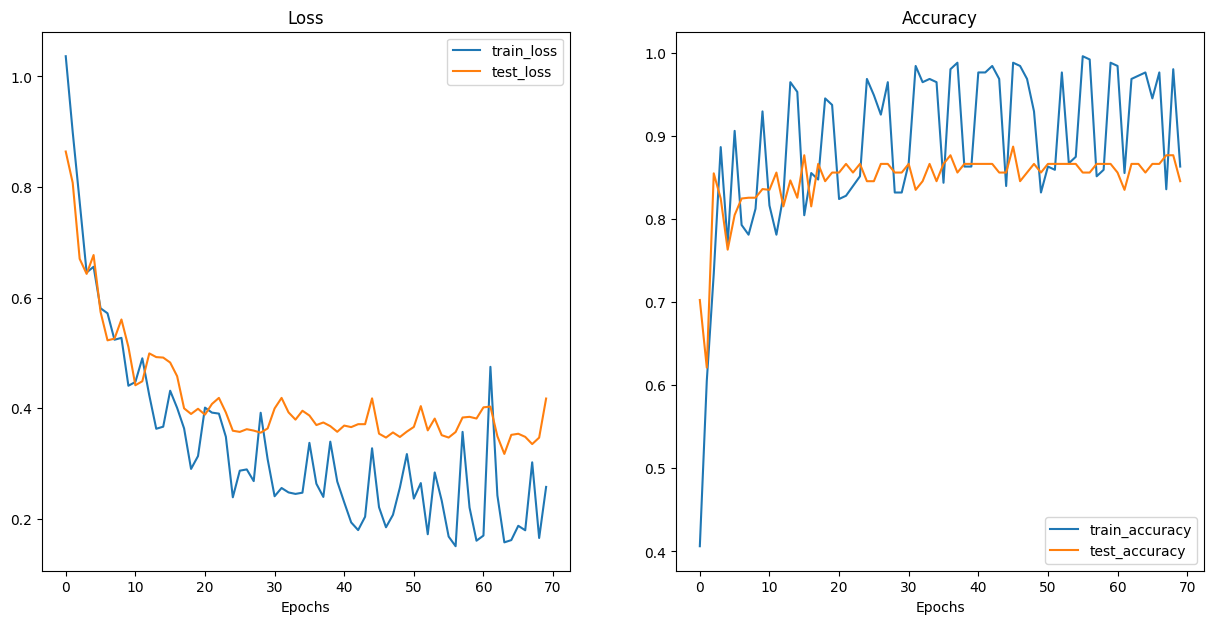

In [16]:
# Evaluating model's curves
plot_loss_curves(results)

## Make predictions on test set


In [17]:
# Selecting random images
num_images = 3
test_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_path_sample = random.sample(population=test_path_list, k=num_images)

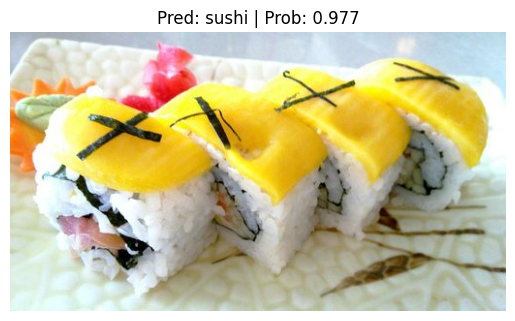

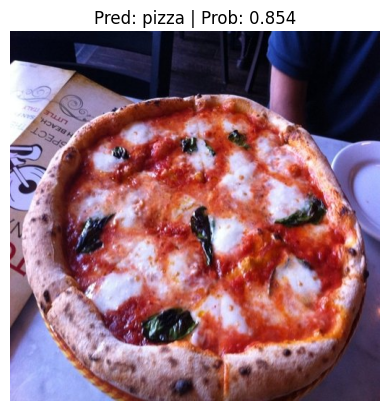

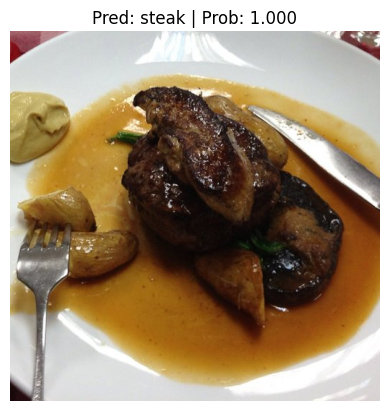

In [18]:
# Making predictions
for image_path in test_path_sample:
    pred_and_plot_image(
        model=model,
        image_path=image_path.as_posix(),
        class_names=class_names,
        transform=weights.transforms(),
        device=device,
    )